# Direct Completion Prompt 

In [62]:
#prompting gpt through the direct method for the Test set
import pandas as pd
import openai

# Load your OpenAI API key
openai.api_key = 'your-api-key'

def load_data(file_path):
    df = pd.read_csv(file_path)
    print("Columns in the file:", df.columns)
    return df

def generate_prompts_and_next_words(text, token_count=50, next_words_count=30, num_prompts=5):
    words = text.split()
    prompts = []
    if len(words) > token_count:
        for i in range(num_prompts):
            start_index = i * token_count
            if start_index + token_count + next_words_count <= len(words):
                prompt = ' '.join(words[start_index:start_index + token_count])
                remaining_words = ' '.join(words[start_index + token_count:])
                next_words = ' '.join(words[start_index + token_count:start_index + token_count + next_words_count])
                prompts.append((prompt, remaining_words, next_words))
    return prompts

def generate_text_with_gpt4_turbo(prompt):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[{"role": "user", "content": f"Continue the following text: {prompt}"}],
            max_tokens=30,
            temperature=0,
        )
        return response['choices'][0]['message']['content'].strip()
    except Exception as e:
        return f"Failed to generate text due to API error: {str(e)}"

def process_books(file_path):
    data = load_data(file_path)
    results = []

    book_col = 'Book'
    author_col = 'Author'
    text_col = 'Text'

    for _, row in data.iterrows():
        if all(col in data.columns for col in [book_col, author_col, text_col]):
            book = row[book_col]
            author = row[author_col]
            text = row[text_col]
            if isinstance(text, str):
                prompts_and_next_words = generate_prompts_and_next_words(text)
                for prompt, remaining_words, next_words in prompts_and_next_words:
                    generated_text = generate_text_with_gpt4_turbo(prompt)
                    results.append({
                        'Book': book,
                        'Author': author,
                        'Prompt': prompt,
                        'Next Words': next_words,
                        'Generated Text': generated_text,
                        'Remaining Text': remaining_words
                    })
            else:
                print(f"Skipping row with non-string text: {text}")
        else:
            print(f"Column names are incorrect. Check the data in {file_path}")
            return

    result_df = pd.DataFrame(results)
    result_df.to_csv('output_books_test_direct.csv', index=False)

process_books('books_test.csv')

Columns in the file: Index(['Book', 'Author', 'Text'], dtype='object')


In [2]:
#prompting gpt through the direct method for the Baseline set
import pandas as pd
import openai

# Load your OpenAI API key
openai.api_key = 'your-api-key'

def load_data(file_path):
    df = pd.read_csv(file_path)
    print("Columns in the file:", df.columns)
    return df

def generate_prompts_and_next_words(text, token_count=50, next_words_count=30, num_prompts=5):
    words = text.split()
    prompts = []
    if len(words) > token_count:
        for i in range(num_prompts):
            start_index = i * token_count
            if start_index + token_count + next_words_count <= len(words):
                prompt = ' '.join(words[start_index:start_index + token_count])
                remaining_words = ' '.join(words[start_index + token_count:])
                next_words = ' '.join(words[start_index + token_count:start_index + token_count + next_words_count])
                prompts.append((prompt, remaining_words, next_words))
    return prompts

def generate_text_with_gpt4_turbo(prompt):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[{"role": "user", "content": f"Continue the following text: {prompt}"}],
            max_tokens=30,
            temperature=0,
        )
        return response['choices'][0]['message']['content'].strip()
    except Exception as e:
        return f"Failed to generate text due to API error: {str(e)}"

def process_books(file_path):
    data = load_data(file_path)
    results = []

    book_col = 'Book'
    author_col = 'Author'
    text_col = 'Text'

    for _, row in data.iterrows():
        if all(col in data.columns for col in [book_col, author_col, text_col]):
            book = row[book_col]
            author = row[author_col]
            text = row[text_col]
            if isinstance(text, str):
                prompts_and_next_words = generate_prompts_and_next_words(text)
                for prompt, remaining_words, next_words in prompts_and_next_words:
                    generated_text = generate_text_with_gpt4_turbo(prompt)
                    results.append({
                        'Book': book,
                        'Author': author,
                        'Prompt': prompt,
                        'Next Words': next_words,
                        'Generated Text': generated_text,
                        'Remaining Text': remaining_words
                    })
            else:
                print(f"Skipping row with non-string text: {text}")
        else:
            print(f"Column names are incorrect. Check the data in {file_path}")
            return

    result_df = pd.DataFrame(results)
    result_df.to_csv('output_books_baseline_direct.csv', index=False)

process_books('books_baseline.csv')

Columns in the file: Index(['Book', 'Author', 'Text'], dtype='object')


# Direct Completion  - Visualisation


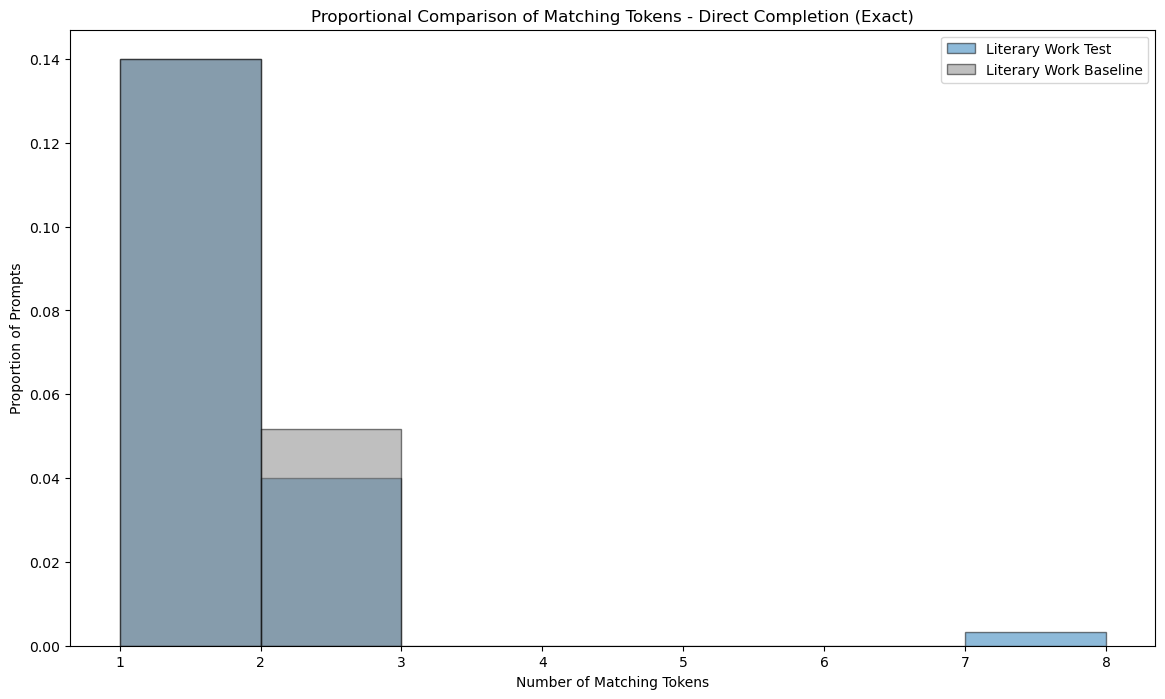

In [14]:
#Visualise the results for the exact matching method to see differences between test and baseline sets
import pandas as pd
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

# Function to count matching tokens with exact matching
def count_fuzzy_matching_tokens(text1, text2, threshold=1):
    words1 = text1.split()
    words2 = text2.split()
    count = 0
    for word1, word2 in zip(words1, words2):
        similarity = SequenceMatcher(None, word1, word2).ratio()
        if similarity >= threshold:
            count += 1
        else:
            break
    return count

# Function to add the 'Matching Tokens' column with exact matching
def add_matching_tokens_column(data, threshold=1):
    matching_counts = []

    for index, row in data.iterrows():
        text = row['Next Words']
        quote = row['Generated Text']
        matching_count = count_fuzzy_matching_tokens(text, quote, threshold)
        matching_counts.append(matching_count)

    data['Matching Tokens'] = matching_counts
    return data

# Function to visualize matching tokens proportionally
def visualize_matching_tokens_proportionally(data1, data2, labels):
    data1_filtered = data1[data1['Matching Tokens'] > 0]
    data2_filtered = data2[data2['Matching Tokens'] > 0]

    total_prompts_data1 = len(data1)
    total_prompts_data2 = len(data2)

    plt.figure(figsize=(14, 8))

    plt.hist(data1_filtered['Matching Tokens'], bins=range(1, max(data1_filtered['Matching Tokens']) + 1, 1), 
             weights=[1/total_prompts_data1]*len(data1_filtered), alpha=0.5, label=labels[0], edgecolor='black')
    plt.hist(data2_filtered['Matching Tokens'], bins=range(1, max(data2_filtered['Matching Tokens']) + 1, 1), 
             weights=[1/total_prompts_data2]*len(data2_filtered), alpha=0.5, label=labels[1], edgecolor='black', color='grey')

    plt.title('Proportional Comparison of Matching Tokens - Direct Completion (Exact)')
    plt.xlabel('Number of Matching Tokens')
    plt.ylabel('Proportion of Prompts')
    plt.legend(loc='upper right')
    plt.show()

# Read the input CSV files
data_combined = pd.read_csv('output_books_test_direct.csv')
data_baseline = pd.read_csv('output_books_baseline_direct.csv')

# Add the 'Matching Tokens' column with fuzzy matching
data_combined_with_matching_tokens = add_matching_tokens_column(data_combined)
data_baseline_with_matching_tokens = add_matching_tokens_column(data_baseline)

# Save the final data to new CSV files
data_combined_with_matching_tokens.to_csv('output_test_with_matching_tokens_direct_exact.csv', index=False)
data_baseline_with_matching_tokens.to_csv('output_baseline_with_matching_tokens_direct_exact.csv', index=False)

# Visualize the matching tokens for both datasets proportionally
visualize_matching_tokens_proportionally(data_combined_with_matching_tokens, data_baseline_with_matching_tokens, ['Literary Work Test', 'Literary Work Baseline'])

In [27]:
#Check stat significance
import pandas as pd
from scipy.stats import mannwhitneyu

# Load the data from CSV files
data_combined = pd.read_csv('output_test_with_matching_tokens_direct_exact')
data_baseline = pd.read_csv('output_baseline_with_matching_tokens_direct_exact')

# Extract 'Matching Tokens' data
tokens_combined = data_combined['Matching Tokens']
tokens_baseline = data_baseline['Matching Tokens']

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(tokens_combined, tokens_baseline, alternative='two-sided')

print("Mann-Whitney U test statistic:", stat)
print("P-value:", p_value)


Mann-Whitney U test statistic: 28672.0
P-value: 0.7907853160993594


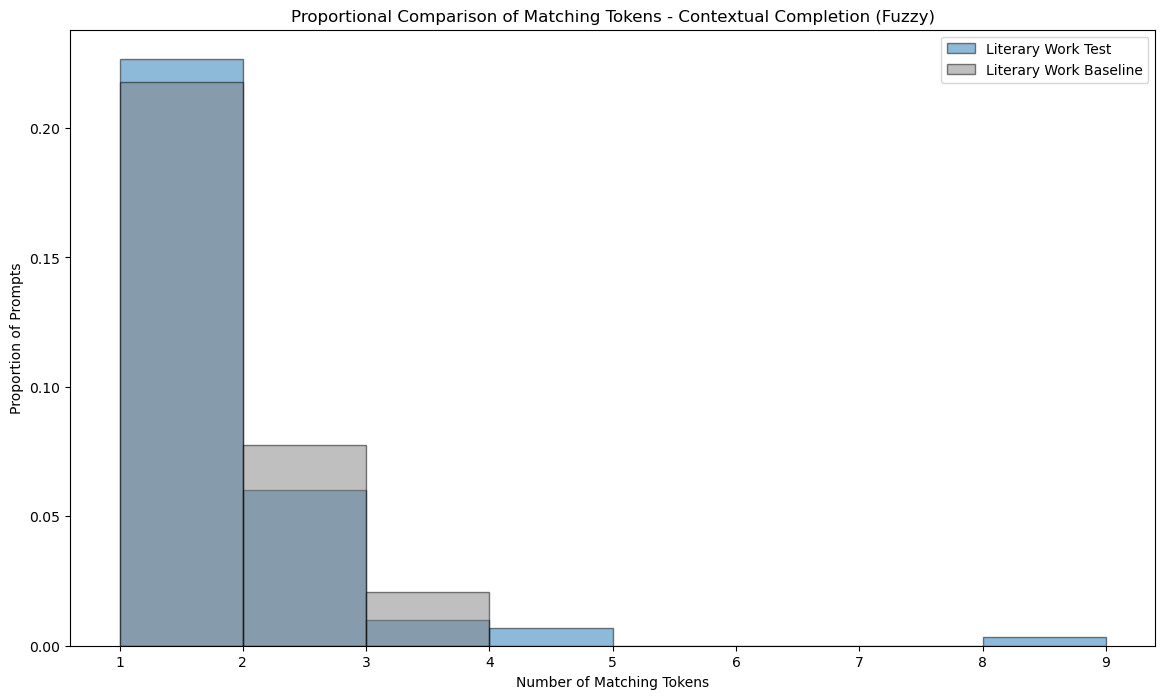

In [13]:
#Visualise the results for the fuzzy matching method to see differences between test and baseline sets

import pandas as pd
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

# Function to count matching tokens with fuzzy matching
def count_fuzzy_matching_tokens(text1, text2, threshold=0.8):
    words1 = text1.split()
    words2 = text2.split()
    count = 0
    for word1, word2 in zip(words1, words2):
        similarity = SequenceMatcher(None, word1, word2).ratio()
        if similarity >= threshold:
            count += 1
        else:
            break
    return count

# Function to add the 'Matching Tokens' column with fuzzy matching
def add_matching_tokens_column(data, threshold=0.8):
    matching_counts = []

    for index, row in data.iterrows():
        text = row['Next Words']
        quote = row['Generated Text']
        matching_count = count_fuzzy_matching_tokens(text, quote, threshold)
        matching_counts.append(matching_count)

    data['Matching Tokens'] = matching_counts
    return data

# Function to visualize matching tokens proportionally
def visualize_matching_tokens_proportionally(data1, data2, labels):
    data1_filtered = data1[data1['Matching Tokens'] > 0]
    data2_filtered = data2[data2['Matching Tokens'] > 0]

    total_prompts_data1 = len(data1)
    total_prompts_data2 = len(data2)

    plt.figure(figsize=(14, 8))

    plt.hist(data1_filtered['Matching Tokens'], bins=range(1, max(data1_filtered['Matching Tokens']) + 1, 1), 
             weights=[1/total_prompts_data1]*len(data1_filtered), alpha=0.5, label=labels[0], edgecolor='black')
    plt.hist(data2_filtered['Matching Tokens'], bins=range(1, max(data2_filtered['Matching Tokens']) + 1, 1), 
             weights=[1/total_prompts_data2]*len(data2_filtered), alpha=0.5, label=labels[1], edgecolor='black', color='grey')

    plt.title('Proportional Comparison of Matching Tokens - Contextual Completion (Fuzzy)')
    plt.xlabel('Number of Matching Tokens')
    plt.ylabel('Proportion of Prompts')
    plt.legend(loc='upper right')
    plt.show()

# Read the input CSV files
data_combined = pd.read_csv('output_books_test_direct.csv')
data_baseline = pd.read_csv('output_books_baseline_direct.csv')

# Add the 'Matching Tokens' column with fuzzy matching
data_combined_with_matching_tokens = add_matching_tokens_column(data_combined)
data_baseline_with_matching_tokens = add_matching_tokens_column(data_baseline)

# Save the final data to new CSV files
data_combined_with_matching_tokens.to_csv('output_test_with_matching_tokens_direct_fuzzy.csv', index=False)
data_baseline_with_matching_tokens.to_csv('output_baseline_with_matching_tokens_direct_fuzzy.csv', index=False)

# Visualize the matching tokens for both datasets proportionally
visualize_matching_tokens_proportionally(data_combined_with_matching_tokens, data_baseline_with_matching_tokens, ['Literary Work Test', 'Literary Work Baseline'])

In [28]:
#Check stat significance
import pandas as pd
from scipy.stats import mannwhitneyu

# Load the data from CSV files
data_combined = pd.read_csv('output_test_with_matching_tokens_direct_fuzzy.csv')
data_baseline = pd.read_csv('output_baseline_with_matching_tokens_direct_fuzzy.csv')

# Extract 'Matching Tokens' data
tokens_combined = data_combined['Matching Tokens']
tokens_baseline = data_baseline['Matching Tokens']

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(tokens_combined, tokens_baseline, alternative='two-sided')

print("Mann-Whitney U test statistic:", stat)
print("P-value:", p_value)


Mann-Whitney U test statistic: 28548.5
P-value: 0.749291618219891


# Contextual Completion Prompting

In [14]:
#Prompting gpt through the contextual completion method for the Test set

import pandas as pd
import openai

# Load your OpenAI API key
openai.api_key = 'your-api-key'

def load_data(file_path):
    df = pd.read_csv(file_path)
    print("Columns in the file:", df.columns)
    return df

def generate_prompts_and_next_words(text, token_count=50, next_words_count=30, step=25):
    words = text.split()
    prompts = []
    num_prompts = (len(words) - token_count) // step + 1
    for i in range(num_prompts):
        start_index = i * step
        if start_index + token_count + next_words_count <= len(words):
            prompt = ' '.join(words[start_index:start_index + token_count])
            remaining_words = ' '.join(words[start_index + token_count:])
            next_words = ' '.join(words[start_index + token_count:start_index + token_count + next_words_count])
            prompts.append((prompt, remaining_words, next_words))
    return prompts


def get_book_quote(book, author, prompt_text):
    system_prompt = {
        "role": "system",
        "content": f'You are “{book}” written by {author}. Your task is to complete quotes according to the book.'
    }

    user_prompt = {
        "role": "user",
        "content": f"{prompt_text}\n"
    }

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[system_prompt, user_prompt],
        temperature=0,
        max_tokens=305,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    return response.choices[0].message['content']

def process_books(file_path):
    data = load_data(file_path)
    results = []

    book_col = 'Book'
    author_col = 'Author'
    text_col = 'Text'

    for _, row in data.iterrows():
        if all(col in data.columns for col in [book_col, author_col, text_col]):
            book = row[book_col]
            author = row[author_col]
            text = row[text_col]
            if isinstance(text, str):
                prompts_and_next_words = generate_prompts_and_next_words(text)
                for prompt, remaining_words, next_words in prompts_and_next_words:
                    generated_text = get_book_quote(book, author, prompt)
                    results.append({
                        'Book': book,
                        'Author': author,
                        'Prompt': prompt,
                        'Next Words': next_words,
                        'Generated Text': generated_text,
                        'Remaining Text': remaining_words
                    })
            else:
                print(f"Skipping row with non-string text: {text}")
        else:
            print(f"Column names are incorrect. Check the data in {file_path}")
            return

    result_df = pd.DataFrame(results)
    result_df.to_csv('output_books_test_context.csv', index=False)

process_books('books_test.csv')


Columns in the file: Index(['Book', 'Author', 'Text'], dtype='object')


In [ ]:
#Prompting gpt through the contextual completion method for the Baseline set

import pandas as pd
import openai

# Load your OpenAI API key
openai.api_key = 'your-api-key'

def load_data(file_path):
    df = pd.read_csv(file_path)
    print("Columns in the file:", df.columns)
    return df

def generate_prompts_and_next_words(text, token_count=50, next_words_count=30, step=25):
    words = text.split()
    prompts = []
    num_prompts = (len(words) - token_count) // step + 1
    for i in range(num_prompts):
        start_index = i * step
        if start_index + token_count + next_words_count <= len(words):
            prompt = ' '.join(words[start_index:start_index + token_count])
            remaining_words = ' '.join(words[start_index + token_count:])
            next_words = ' '.join(words[start_index + token_count:start_index + token_count + next_words_count])
            prompts.append((prompt, remaining_words, next_words))
    return prompts


def get_book_quote(book, author, prompt_text):
    system_prompt = {
        "role": "system",
        "content": f'You are “{book}” written by {author}. Your task is to complete quotes according to the book.'
    }

    user_prompt = {
        "role": "user",
        "content": f"{prompt_text}\n"
    }

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[system_prompt, user_prompt],
        temperature=0,
        max_tokens=305,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    return response.choices[0].message['content']

def process_books(file_path):
    data = load_data(file_path)
    results = []

    book_col = 'Book'
    author_col = 'Author'
    text_col = 'Text'

    for _, row in data.iterrows():
        if all(col in data.columns for col in [book_col, author_col, text_col]):
            book = row[book_col]
            author = row[author_col]
            text = row[text_col]
            if isinstance(text, str):
                prompts_and_next_words = generate_prompts_and_next_words(text)
                for prompt, remaining_words, next_words in prompts_and_next_words:
                    generated_text = get_book_quote(book, author, prompt)
                    results.append({
                        'Book': book,
                        'Author': author,
                        'Prompt': prompt,
                        'Next Words': next_words,
                        'Generated Text': generated_text,
                        'Remaining Text': remaining_words
                    })
            else:
                print(f"Skipping row with non-string text: {text}")
        else:
            print(f"Column names are incorrect. Check the data in {file_path}")
            return

    result_df = pd.DataFrame(results)
    result_df.to_csv('output_books_baseline_context.csv', index=False)

process_books('books_baseline.csv')


# Direct Completion  - Visualisation


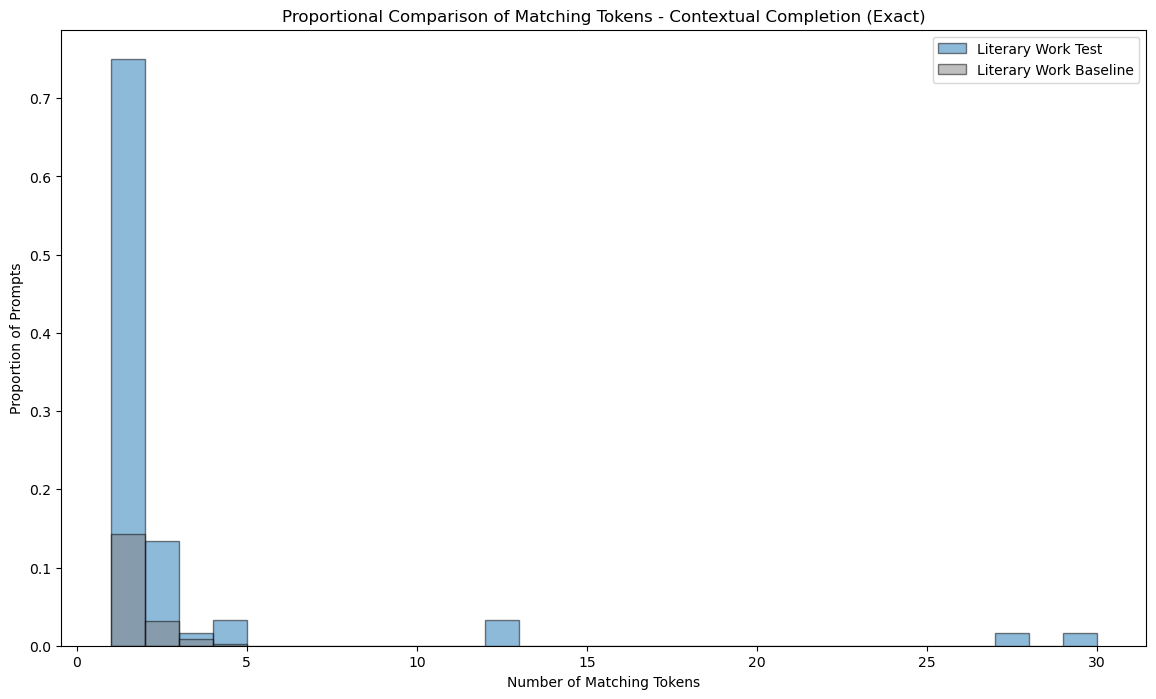

In [15]:
#Visualise the results for the exact matching method to see differences between test and baseline sets

import pandas as pd
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

# Function to count matching tokens with fuzzy matching
def count_fuzzy_matching_tokens(text1, text2, threshold=1):
    words1 = text1.split()
    words2 = text2.split()
    count = 0
    for word1, word2 in zip(words1, words2):
        similarity = SequenceMatcher(None, word1, word2).ratio()
        if similarity >= threshold:
            count += 1
        else:
            break
    return count

# Function to add the 'Matching Tokens' column with fuzzy matching
def add_matching_tokens_column(data, threshold=1):
    matching_counts = []

    for index, row in data.iterrows():
        text = row['Next Words']
        quote = row['Generated Text']
        matching_count = count_fuzzy_matching_tokens(text, quote, threshold)
        matching_counts.append(matching_count)

    data['Matching Tokens'] = matching_counts
    return data

# Function to visualize matching tokens proportionally
def visualize_matching_tokens_proportionally(data1, data2, labels):
    data1_filtered = data1[data1['Matching Tokens'] > 0]
    data2_filtered = data2[data2['Matching Tokens'] > 0]

    total_prompts_data1 = len(data1)
    total_prompts_data2 = len(data2)

    plt.figure(figsize=(14, 8))

    plt.hist(data1_filtered['Matching Tokens'], bins=range(1, max(data1_filtered['Matching Tokens']) + 1, 1), 
             weights=[1/total_prompts_data1]*len(data1_filtered), alpha=0.5, label=labels[0], edgecolor='black')
    plt.hist(data2_filtered['Matching Tokens'], bins=range(1, max(data2_filtered['Matching Tokens']) + 1, 1), 
             weights=[1/total_prompts_data2]*len(data2_filtered), alpha=0.5, label=labels[1], edgecolor='black', color='grey')

    plt.title('Proportional Comparison of Matching Tokens - Contextual Completion (Exact)')
    plt.xlabel('Number of Matching Tokens')
    plt.ylabel('Proportion of Prompts')
    plt.legend(loc='upper right')
    plt.show()

# Read the input CSV files
data_combined = pd.read_csv('output_books__test_context.csv')
data_baseline = pd.read_csv('output_books_baseline_context.csv')

# Add the 'Matching Tokens' column with fuzzy matching
data_combined_with_matching_tokens = add_matching_tokens_column(data_combined)
data_baseline_with_matching_tokens = add_matching_tokens_column(data_baseline)

# Save the final data to new CSV files
data_combined_with_matching_tokens.to_csv('output_test_with_matching_tokens_direct_exact.csv', index=False)
data_baseline_with_matching_tokens.to_csv('output_baseline_with_matching_tokens_direct_exact.csv', index=False)

# Visualize the matching tokens for both datasets proportionally
visualize_matching_tokens_proportionally(data_combined_with_matching_tokens, data_baseline_with_matching_tokens, ['Literary Work Test', 'Literary Work Baseline'])


In [29]:
#check stat significance
import pandas as pd
from scipy.stats import mannwhitneyu

# Load the data from CSV files
data_combined = pd.read_csv('output_test_with_matching_tokens_direct_exact.csv')
data_baseline = pd.read_csv('output_baseline_with_matching_tokens_direct_exact.csv')

# Extract 'Matching Tokens' data
tokens_combined = data_combined['Matching Tokens']
tokens_baseline = data_baseline['Matching Tokens']

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(tokens_combined, tokens_baseline, alternative='two-sided')

print("Mann-Whitney U test statistic:", stat)
print("P-value:", p_value)


Mann-Whitney U test statistic: 26025.0
P-value: 2.723382607406912e-40


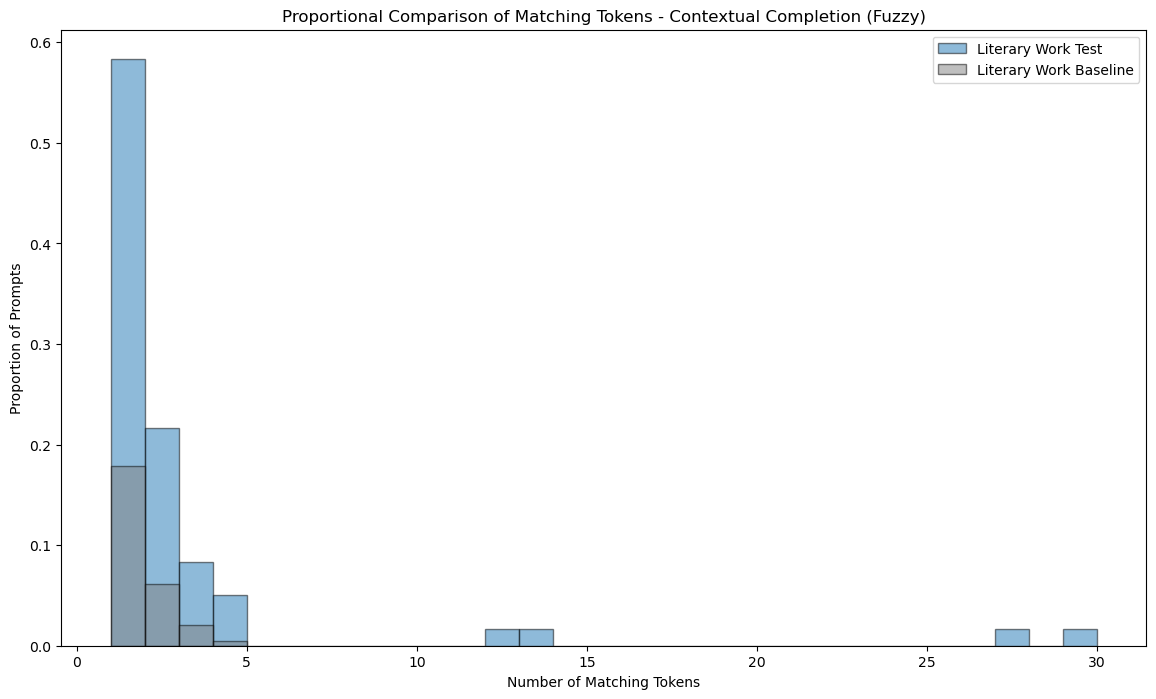

In [16]:
#Visualise the results for the fuzzy matching method to see differences between test and baseline sets

import pandas as pd
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

# Function to count matching tokens with fuzzy matching
def count_fuzzy_matching_tokens(text1, text2, threshold=0.8):
    words1 = text1.split()
    words2 = text2.split()
    count = 0
    for word1, word2 in zip(words1, words2):
        similarity = SequenceMatcher(None, word1, word2).ratio()
        if similarity >= threshold:
            count += 1
        else:
            break
    return count

# Function to add the 'Matching Tokens' column with fuzzy matching
def add_matching_tokens_column(data, threshold=0.8):
    matching_counts = []

    for index, row in data.iterrows():
        text = row['Next Words']
        quote = row['Generated Text']
        matching_count = count_fuzzy_matching_tokens(text, quote, threshold)
        matching_counts.append(matching_count)

    data['Matching Tokens'] = matching_counts
    return data

# Function to visualize matching tokens proportionally
def visualize_matching_tokens_proportionally(data1, data2, labels):
    data1_filtered = data1[data1['Matching Tokens'] > 0]
    data2_filtered = data2[data2['Matching Tokens'] > 0]

    total_prompts_data1 = len(data1)
    total_prompts_data2 = len(data2)

    plt.figure(figsize=(14, 8))

    plt.hist(data1_filtered['Matching Tokens'], bins=range(1, max(data1_filtered['Matching Tokens']) + 1, 1), 
             weights=[1/total_prompts_data1]*len(data1_filtered), alpha=0.5, label=labels[0], edgecolor='black')
    plt.hist(data2_filtered['Matching Tokens'], bins=range(1, max(data2_filtered['Matching Tokens']) + 1, 1), 
             weights=[1/total_prompts_data2]*len(data2_filtered), alpha=0.5, label=labels[1], edgecolor='black', color='grey')

    plt.title('Proportional Comparison of Matching Tokens - Contextual Completion (Fuzzy)')
    plt.xlabel('Number of Matching Tokens')
    plt.ylabel('Proportion of Prompts')
    plt.legend(loc='upper right')
    plt.show()

# Read the input CSV files
data_combined = pd.read_csv('output_books_test_context.csv')
data_baseline = pd.read_csv('output_books_baseline_context.csv')

# Add the 'Matching Tokens' column with fuzzy matching
data_combined_with_matching_tokens = add_matching_tokens_column(data_combined)
data_baseline_with_matching_tokens = add_matching_tokens_column(data_baseline)

# Save the final data to new CSV files
data_combined_with_matching_tokens.to_csv('output_test_with_matching_tokens_direct_fuzzy.csv', index=False)
data_baseline_with_matching_tokens.to_csv('output_baseline_with_matching_tokens_direct_fuzzy.csv', index=False)

# Visualize the matching tokens for both datasets proportionally
visualize_matching_tokens_proportionally(data_combined_with_matching_tokens, data_baseline_with_matching_tokens, ['Literary Work Test', 'Literary Work Baseline'])

In [30]:
#check stat significance
import pandas as pd
from scipy.stats import mannwhitneyu

# Load the data from CSV files
data_combined = pd.read_csv('output_test_with_matching_tokens_direct_fuzzy.csv')
data_baseline = pd.read_csv('output_baseline_with_matching_tokens_direct_fuzzy.csv')

# Extract 'Matching Tokens' data
tokens_combined = data_combined['Matching Tokens']
tokens_baseline = data_baseline['Matching Tokens']

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(tokens_combined, tokens_baseline, alternative='two-sided')

print("Mann-Whitney U test statistic:", stat)
print("P-value:", p_value)


Mann-Whitney U test statistic: 25253.5
P-value: 1.0417668504747557e-30


# First sentence request

In [22]:
#Prompting gpt through the contextual completion method for the Test set

import pandas as pd
import openai

# Initialize the OpenAI client with your API key
openai.api_key = "your-api-key"

# Read the input CSV file
input_file = 'books_test.csv'
output_file = 'first_sentence_test.csv'
df = pd.read_csv(input_file)

# Define a function to generate the prompt and get the response
def get_book_quote(book, author):
    system_prompt = {
        "role": "system",
        "content": f"Jestes “{book}” autorstwa {author}. Twoim zadaniem jest uzupełnianie cytatów."
    }
    user_prompt = {
        "role": "user",
        "content": "Podaj mi początkowe zdanie według treści książki. Potrzebuje tego do celow edukacyjnych."
    }

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[system_prompt, user_prompt],
        temperature=0,
        max_tokens=305,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    return response.choices[0].message['content']

# Iterate over each row in the DataFrame and get the quote
quotes = []
for index, row in df.iterrows():
    book = row['Book']
    author = row['Author']
    text = row['Text']
    quote = get_book_quote(book, author)
    quotes.append({'Book': book, 'Author': author, 'Text': text, 'Quote': quote})

# Save the quotes to a new CSV file
output_df = pd.DataFrame(quotes)
output_df.to_csv(output_file, index=False)

print(f"Quotes have been saved to {output_file}")

Quotes have been saved to first_sentence_baseline_pt2.csv


In [ ]:
import pandas as pd
import openai

# Initialize the OpenAI client with your API key
openai.api_key = "your-api-key"

# Read the input CSV file
input_file = 'books_baseline.csv'
output_file = 'first_sentence_baseline.csv'
df = pd.read_csv(input_file)

# Define a function to generate the prompt and get the response
def get_book_quote(book, author):
    system_prompt = {
        "role": "system",
        "content": f"Jestes “{book}” autorstwa {author}. Twoim zadaniem jest uzupełnianie cytatów."
    }
    user_prompt = {
        "role": "user",
        "content": "Podaj mi początkowe zdania według treści książki/wiersza. Podawaj tylko cytaty i nie mow nic innego.\n"
    }

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[system_prompt, user_prompt],
        temperature=0,
        max_tokens=305,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    return response.choices[0].message['content']

# Iterate over each row in the DataFrame and get the quote
quotes = []
for index, row in df.iterrows():
    book = row['Book']
    author = row['Author']
    text = row['Text']
    quote = get_book_quote(book, author)
    quotes.append({'Book': book, 'Author': author, 'Text': text, 'Quote': quote})

# Save the quotes to a new CSV file
output_df = pd.DataFrame(quotes)
output_df.to_csv(output_file, index=False)

print(f"Quotes have been saved to {output_file}")

# First sentence prompting - Visualisation

[nltk_data] Downloading package punkt to /Users/asia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processed row 0: Matching Tokens = 0
Processed row 1: Matching Tokens = 0
Processed row 2: Matching Tokens = 6
Processed row 3: Matching Tokens = 17
Processed row 4: Matching Tokens = 0
Processed row 5: Matching Tokens = 19
Processed row 6: Matching Tokens = 3
Processed row 7: Matching Tokens = 0
Processed row 8: Matching Tokens = 5
Processed row 9: Matching Tokens = 13
Processed row 10: Matching Tokens = 6
Processed row 11: Matching Tokens = 15
Processed row 12: Matching Tokens = 83
Processed row 13: Matching Tokens = 0
Processed row 14: Matching Tokens = 0
Processed row 15: Matching Tokens = 0
Processed row 16: Matching Tokens = 0
Processed row 17: Matching Tokens = 6
Processed row 18: Matching Tokens = 0
Processed row 19: Matching Tokens = 0
Processed row 20: Matching Tokens = 5
Processed row 21: Matching Tokens = 0
Processed row 22: Matching Tokens = 0
Processed row 23: Matching Tokens = 0
Processed row 24: Matching Tokens = 0
Processed row 25: Matching Tokens = 0
Processed row 26:

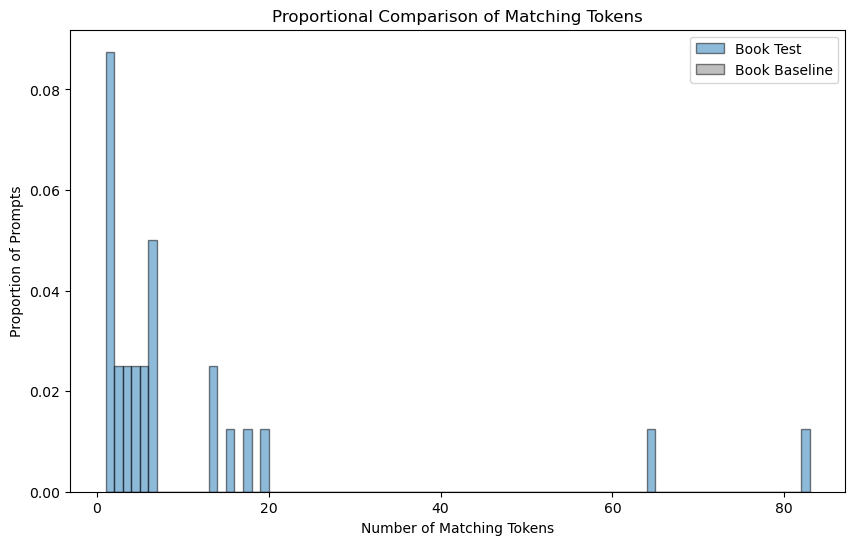

In [1]:
#Visualise the results for the test matching method to see differences between test and baseline sets
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
from difflib import SequenceMatcher

# Download necessary NLTK resources
nltk.download('punkt')

# Function to count matching tokens with test matching
def count_matching_tokens(text1, text2, threshold=1):
    words1 = word_tokenize(text1, language='polish')
    words2 = word_tokenize(text2, language='polish')
    count = 0
    for word1, word2 in zip(words1, words2):
        similarity = SequenceMatcher(None, word1, word2).ratio()
        if similarity >= threshold:
            count += 1
        else:
            break
    return count

# Function to add the 'Matching Tokens' column with test matching
def add_matching_tokens_column(data, threshold=1):
    matching_counts = []

    for index, row in data.iterrows():
        text = str(row['Text'])  # Ensure the text is a string
        quote = str(row['Quote'])  # Ensure the quote is a string
        matching_count = count_matching_tokens(text, quote, threshold)
        matching_counts.append(matching_count)
        print(f"Processed row {index}: Matching Tokens = {matching_count}")

    data['Matching Tokens'] = matching_counts
    return data

# Function to visualize matching tokens proportionally
def visualize_matching_tokens_proportionally(data1, data2):
    data1_filtered = data1[data1['Matching Tokens'] > 0]
    data2_filtered = data2[data2['Matching Tokens'] > 0]

    total_prompts_data1 = len(data1)
    total_prompts_data2 = len(data2)

    plt.figure(figsize=(10, 6))

    plt.hist(data1_filtered['Matching Tokens'], bins=range(1, max(data1['Matching Tokens'].max(), data2['Matching Tokens'].max()) + 1), 
             weights=[1/total_prompts_data1]*len(data1_filtered), alpha=0.5, label='Book Test', edgecolor='black')
    plt.hist(data2_filtered['Matching Tokens'], bins=range(1, max(data1['Matching Tokens'].max(), data2['Matching Tokens'].max()) + 1), 
             weights=[1/total_prompts_data2]*len(data2_filtered), alpha=0.5, label='Book Baseline', edgecolor='black', color='grey')

    plt.title('Proportional Comparison of Matching Tokens')
    plt.xlabel('Number of Matching Tokens')
    plt.ylabel('Proportion of Prompts')
    plt.legend(loc='upper right')
    plt.show()

# Read the input CSV files
file1 = 'first_sentence_test.csv'
file2 = 'first_sentence_baseline.csv'

data1 = pd.read_csv(file1)
data2 = pd.read_csv(file2)

# Add the 'Matching Tokens' column
data_with_matching_tokens1 = add_matching_tokens_column(data1)
data_with_matching_tokens2 = add_matching_tokens_column(data2)

# Save the final data to new CSV files
output_file1 = 'first_sentence_test_exact.csv'
output_file2 = 'first_sentence_baseline_exact.csv'

data_with_matching_tokens1.to_csv(output_file1, index=False)
data_with_matching_tokens2.to_csv(output_file2, index=False)

# Visualize the matching tokens proportionally
visualize_matching_tokens_proportionally(data_with_matching_tokens1, data_with_matching_tokens2)


In [32]:
#check stat significance
import pandas as pd
from scipy.stats import mannwhitneyu

# Load the data from CSV files
data_combined = pd.read_csv('first_sentence_test_exact.csv')
data_baseline = pd.read_csv('first_sentence_baseline_exact.csv')

# Extract 'Matching Tokens' data
tokens_combined = data_combined['Matching Tokens']
tokens_baseline = data_baseline['Matching Tokens']

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(tokens_combined, tokens_baseline, alternative='two-sided')

print("Mann-Whitney U test statistic:", stat)
print("P-value:", p_value)


Mann-Whitney U test statistic: 2080.0
P-value: 0.00013235447512869686


[nltk_data] Downloading package punkt to /Users/asia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processed row 0: Matching Tokens = 0
Processed row 1: Matching Tokens = 0
Processed row 2: Matching Tokens = 6
Processed row 3: Matching Tokens = 17
Processed row 4: Matching Tokens = 0
Processed row 5: Matching Tokens = 19
Processed row 6: Matching Tokens = 0
Processed row 7: Matching Tokens = 0
Processed row 8: Matching Tokens = 5
Processed row 9: Matching Tokens = 13
Processed row 10: Matching Tokens = 6
Processed row 11: Matching Tokens = 5
Processed row 12: Matching Tokens = 83
Processed row 13: Matching Tokens = 0
Processed row 14: Matching Tokens = 0
Processed row 15: Matching Tokens = 0
Processed row 16: Matching Tokens = 0
Processed row 17: Matching Tokens = 6
Processed row 18: Matching Tokens = 0
Processed row 19: Matching Tokens = 0
Processed row 20: Matching Tokens = 5
Processed row 21: Matching Tokens = 0
Processed row 22: Matching Tokens = 0
Processed row 23: Matching Tokens = 0
Processed row 24: Matching Tokens = 0
Processed row 25: Matching Tokens = 0
Processed row 26: 

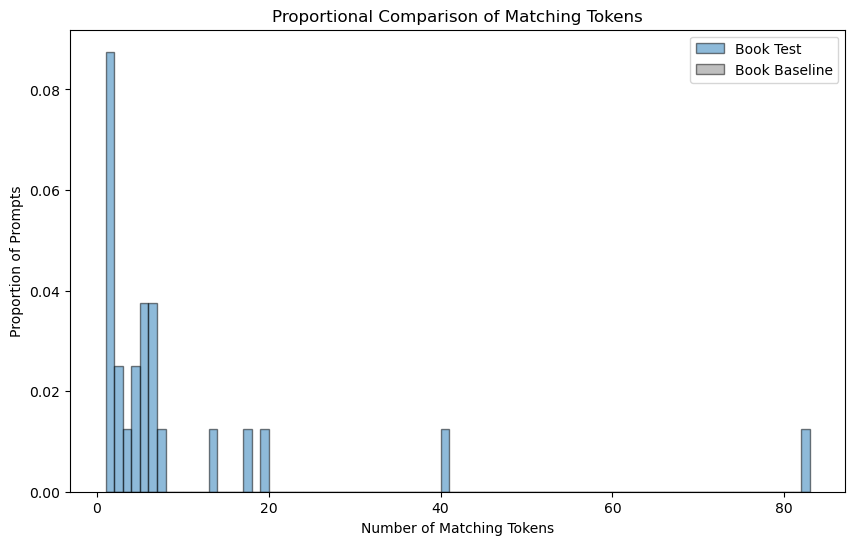

In [2]:
#Visualise the results for the fuzzy matching method to see differences between test and baseline sets
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
from difflib import SequenceMatcher

# Download necessary NLTK resources
nltk.download('punkt')

# Function to count matching tokens with fuzzy matching
def count_matching_tokens(text1, text2, threshold=0.8):
    words1 = word_tokenize(text1, language='polish')
    words2 = word_tokenize(text2, language='polish')
    count = 0
    for word1, word2 in zip(words1, words2):
        similarity = SequenceMatcher(None, word1, word2).ratio()
        if similarity >= threshold:
            count += 1
        else:
            break
    return count

# Function to add the 'Matching Tokens' column with fuzzy matching
def add_matching_tokens_column(data, threshold=0.8):
    matching_counts = []

    for index, row in data.iterrows():
        text = str(row['Text'])  # Ensure the text is a string
        quote = str(row['Quote'])  # Ensure the quote is a string
        matching_count = count_matching_tokens(text, quote, threshold)
        matching_counts.append(matching_count)
        print(f"Processed row {index}: Matching Tokens = {matching_count}")

    data['Matching Tokens'] = matching_counts
    return data

# Function to visualize matching tokens proportionally
def visualize_matching_tokens_proportionally(data1, data2):
    data1_filtered = data1[data1['Matching Tokens'] > 0]
    data2_filtered = data2[data2['Matching Tokens'] > 0]

    total_prompts_data1 = len(data1)
    total_prompts_data2 = len(data2)

    plt.figure(figsize=(10, 6))

    plt.hist(data1_filtered['Matching Tokens'], bins=range(1, max(data1['Matching Tokens'].max(), data2['Matching Tokens'].max()) + 1), 
             weights=[1/total_prompts_data1]*len(data1_filtered), alpha=0.5, label='Book Test', edgecolor='black')
    plt.hist(data2_filtered['Matching Tokens'], bins=range(1, max(data1['Matching Tokens'].max(), data2['Matching Tokens'].max()) + 1), 
             weights=[1/total_prompts_data2]*len(data2_filtered), alpha=0.5, label='Book Baseline', edgecolor='black', color='grey')

    plt.title('Proportional Comparison of Matching Tokens')
    plt.xlabel('Number of Matching Tokens')
    plt.ylabel('Proportion of Prompts')
    plt.legend(loc='upper right')
    plt.show()

# Read the input CSV files
file1 = 'first_sentence_test.csv'
file2 = 'first_sentence_baseline.csv'

data1 = pd.read_csv(file1)
data2 = pd.read_csv(file2)

# Add the 'Matching Tokens' column
data_with_matching_tokens1 = add_matching_tokens_column(data1)
data_with_matching_tokens2 = add_matching_tokens_column(data2)

# Save the final data to new CSV files
output_file1 = 'first_sentence_test_fuzzy.csv'
output_file2 = 'first_sentence_baseline_fuzzy.csv'

data_with_matching_tokens1.to_csv(output_file1, index=False)
data_with_matching_tokens2.to_csv(output_file2, index=False)

# Visualize the matching tokens proportionally
visualize_matching_tokens_proportionally(data_with_matching_tokens1, data_with_matching_tokens2)


In [34]:
#check stat significance
import pandas as pd
from scipy.stats import mannwhitneyu

# Load the data from CSV files
data_combined = pd.read_csv('first_sentence_test_fuzzy.csv')
data_baseline = pd.read_csv('first_sentence_baseline_fuzzy.csv')

# Extract 'Matching Tokens' data
tokens_combined = data_combined['Matching Tokens']
tokens_baseline = data_baseline['Matching Tokens']

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(tokens_combined, tokens_baseline, alternative='two-sided')

print("Mann-Whitney U test statistic:", stat)
print("P-value:", p_value)

Mann-Whitney U test statistic: 2120.0
P-value: 5.96973757251668e-05
